In [1]:
import kagglehub

path = kagglehub.dataset_download("snehaanbhawal/resume-dataset")
print(path)


Using Colab cache for faster access to the 'resume-dataset' dataset.
/kaggle/input/resume-dataset


In [2]:
import os

os.listdir(path)


['Resume', 'data']

In [9]:
import pandas as pd
import re

df = pd.read_csv("Resume.csv")
df.drop_duplicates(inplace=True)
print("\nInitial Dataset Shape:")
print(df.shape)





Initial Dataset Shape:
(2484, 4)


In [10]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64


In [12]:

print("\nDuplicate Records Before Removal:")
print(df.duplicated().sum())

df.drop_duplicates(inplace=True)

print("\nDataset Shape After Removing Duplicates:")
print(df.shape)


Duplicate Records Before Removal:
0

Dataset Shape After Removing Duplicates:
(2484, 4)


In [13]:
df['resume_length'] = df['Resume_str'].apply(len)

print("\nResume Length Statistics:")
print(df['resume_length'].describe())


Resume Length Statistics:
count     2484.000000
mean      6295.308776
std       2769.251458
min         21.000000
25%       5160.000000
50%       5886.500000
75%       7227.250000
max      38842.000000
Name: resume_length, dtype: float64


In [14]:
Q1 = df['resume_length'].quantile(0.25)
Q3 = df['resume_length'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['resume_length'] >= lower_bound) &
        (df['resume_length'] <= upper_bound)]

print("\nDataset Shape After Removing Outliers:")
print(df.shape)



Dataset Shape After Removing Outliers:
(2275, 5)


In [15]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['cleaned_resume'] = df['Resume_str'].apply(clean_text)

In [16]:
print("\nCleaned Dataset Preview:")
print(df[['cleaned_resume', 'Category']].head())

print("\nFinal Dataset Shape:")
print(df.shape)


Cleaned Dataset Preview:
                                      cleaned_resume Category
0  hr administrator marketing associate hr admini...       HR
1  hr specialist us hr operations summary versati...       HR
2  hr director summary over years experience in r...       HR
3  hr specialist summary dedicated driven and dyn...       HR
4  hr manager skill highlights hr skills hr depar...       HR

Final Dataset Shape:
(2275, 6)



Statistical Summary:
                 ID  resume_length
count  2.275000e+03    2275.000000
mean   3.167246e+07    5978.573187
std    2.124513e+07    1698.863653
min    3.547447e+06    2060.000000
25%    1.748271e+07    5183.000000
50%    2.512861e+07    5849.000000
75%    3.609860e+07    6955.500000
max    9.980612e+07   10293.000000


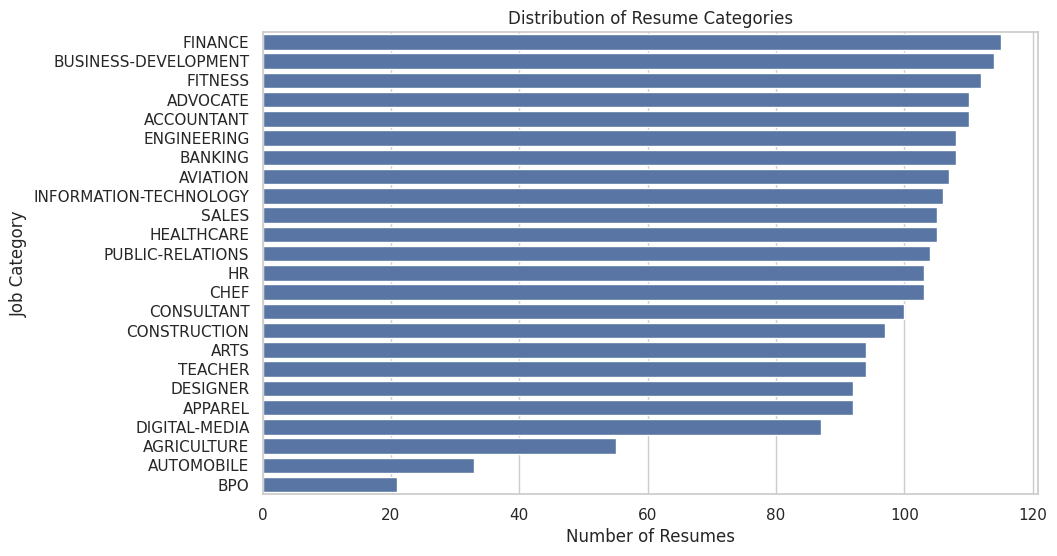

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
print("\nStatistical Summary:")
print(df.describe())

plt.figure(figsize=(10, 6))
sns.countplot(y=df['Category'], order=df['Category'].value_counts().index)
plt.title("Distribution of Resume Categories")
plt.xlabel("Number of Resumes")
plt.ylabel("Job Category")
plt.show()



Category Percentage Distribution:
Category
FINANCE                   5.054945
BUSINESS-DEVELOPMENT      5.010989
FITNESS                   4.923077
ADVOCATE                  4.835165
ACCOUNTANT                4.835165
ENGINEERING               4.747253
BANKING                   4.747253
AVIATION                  4.703297
INFORMATION-TECHNOLOGY    4.659341
SALES                     4.615385
HEALTHCARE                4.615385
PUBLIC-RELATIONS          4.571429
HR                        4.527473
CHEF                      4.527473
CONSULTANT                4.395604
CONSTRUCTION              4.263736
ARTS                      4.131868
TEACHER                   4.131868
DESIGNER                  4.043956
APPAREL                   4.043956
DIGITAL-MEDIA             3.824176
AGRICULTURE               2.417582
AUTOMOBILE                1.450549
BPO                       0.923077
Name: proportion, dtype: float64


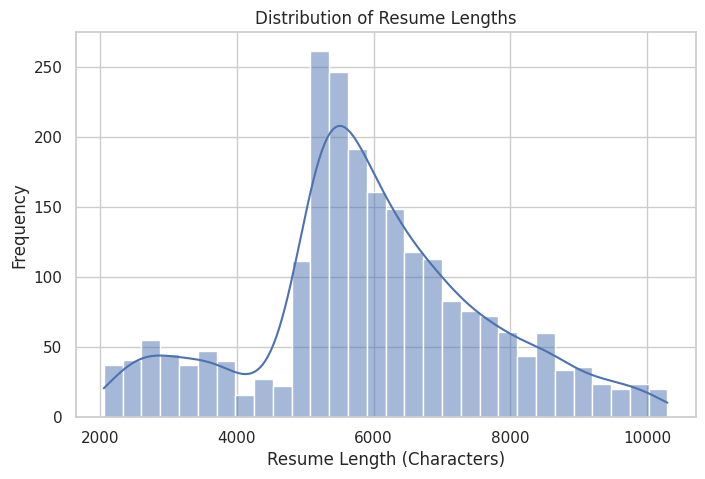

In [19]:

category_percent = df['Category'].value_counts(normalize=True) * 100
print("\nCategory Percentage Distribution:")
print(category_percent)

plt.figure(figsize=(8, 5))
sns.histplot(df['resume_length'], bins=30, kde=True)
plt.title("Distribution of Resume Lengths")
plt.xlabel("Resume Length (Characters)")
plt.ylabel("Frequency")
plt.show()

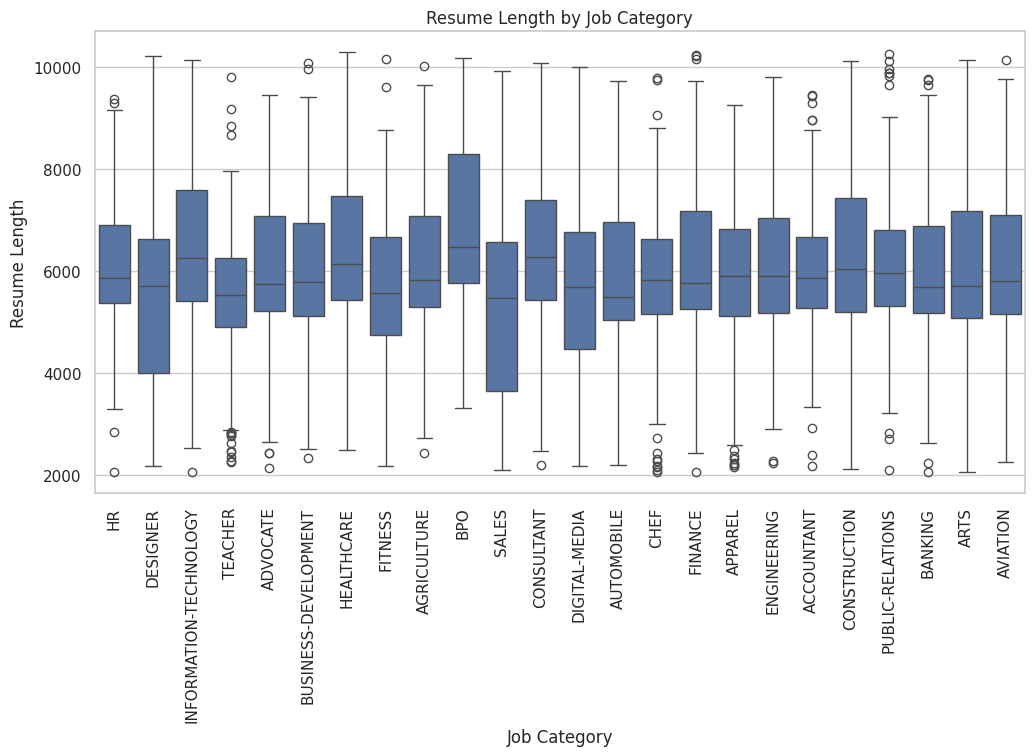

In [20]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='resume_length', data=df)
plt.xticks(rotation=90)
plt.title("Resume Length by Job Category")
plt.xlabel("Job Category")
plt.ylabel("Resume Length")
plt.show()



Top 10 Most Frequent Words:
      Word  Frequency
0      and     106683
1       to      47273
2       of      37581
3      the      31776
4       in      24969
5      for      24527
6     with      18952
7        a      15006
8    state      14495
9  company      13579


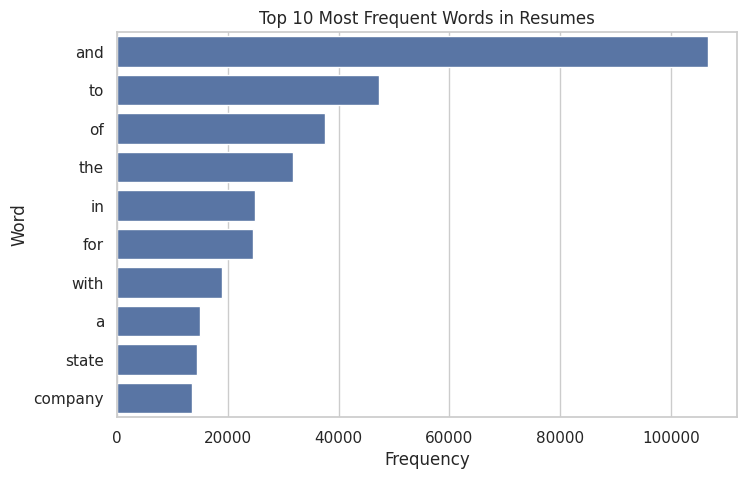

In [21]:
# -----------------------------------------
from collections import Counter

all_words = " ".join(df['cleaned_resume']).split()
word_freq = Counter(all_words)

top_words = word_freq.most_common(10)
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

print("\nTop 10 Most Frequent Words:")
print(top_words_df)

plt.figure(figsize=(8, 5))
sns.barplot(x='Frequency', y='Word', data=top_words_df)
plt.title("Top 10 Most Frequent Words in Resumes")
plt.show()

In [23]:
# -----------------------------------------
# STATISTICAL ANALYSIS - ONE WAY ANOVA
# -----------------------------------------

from scipy.stats import f_oneway

# Group resume lengths by category
groups = [
    df[df['Category'] == cat]['resume_length']
    for cat in df['Category'].unique()
]

# Perform ANOVA test
f_stat, p_value = f_oneway(*groups)

print("F-Statistic:", f_stat)
print("P-Value:", p_value)

# Hypothesis Decision
if p_value < 0.05:
    print("Reject Null Hypothesis: Resume lengths differ significantly across categories.")
else:
    print("Fail to Reject Null Hypothesis: No significant difference found.")


F-Statistic: 3.606247606917238
P-Value: 1.6005290836496555e-08
Reject Null Hypothesis: Resume lengths differ significantly across categories.


In [24]:
# -----------------------------------------
# PREDICTIVE MODELING - RESUME CLASSIFICATION
# -----------------------------------------

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Features & Target
X = df['cleaned_resume']
y = df['Category']

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

# Model Training
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.6505494505494506

Classification Report:

                        precision    recall  f1-score   support

            ACCOUNTANT       0.63      0.71      0.67        17
              ADVOCATE       0.48      0.41      0.44        29
           AGRICULTURE       0.75      0.30      0.43        10
               APPAREL       0.70      0.41      0.52        17
                  ARTS       0.62      0.26      0.37        19
            AUTOMOBILE       0.00      0.00      0.00         5
              AVIATION       0.59      0.71      0.65        14
               BANKING       0.55      0.55      0.55        20
                   BPO       0.00      0.00      0.00         2
  BUSINESS-DEVELOPMENT       0.70      0.76      0.73        25
                  CHEF       0.89      0.76      0.82        21
          CONSTRUCTION       0.83      0.94      0.88        16
            CONSULTANT       0.67      0.16      0.26        25
              DESIGNER       0.86      0.71      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# New Section